In [2]:
!pip install lion-pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time
from lion_pytorch import Lion
from tqdm import tqdm

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [7]:
resume = True

if resume: 
    with open('lion_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_lion = arr["acc"]
        test_loss_history_lion = arr["loss"]
        loss_in_training_lion = arr["loss_train"]
        time_learning_lion = arr["time"]
else:
    test_accuracy_history_lion, test_loss_history_lion, loss_in_training_lion, time_learning_lion = {}, {}, {}, {}

In [8]:
test_accuracy_history_lion

{(0.0001, 0.001): [0.664,
  0.757,
  0.7956,
  0.8056,
  0.8194,
  0.8096,
  0.8218,
  0.8204,
  0.823,
  0.8212,
  0.8256,
  0.8272,
  0.8234,
  0.8282,
  0.8268,
  0.8316,
  0.8236,
  0.827,
  0.8266,
  0.8286],
 (0.0001, 0.01): [0.6432,
  0.747,
  0.8002,
  0.8092,
  0.8208,
  0.8152,
  0.8204,
  0.8242,
  0.8162,
  0.829,
  0.8218,
  0.831,
  0.8272,
  0.8332,
  0.836,
  0.8274,
  0.83,
  0.8332,
  0.8324,
  0.83],
 (0.0001, 0): [0.6428,
  0.7604,
  0.8014,
  0.816,
  0.8184,
  0.8162,
  0.8208,
  0.8222,
  0.824,
  0.8236,
  0.8232,
  0.8248,
  0.8202,
  0.8258,
  0.8306,
  0.8248,
  0.8284,
  0.8254,
  0.8328,
  0.8268],
 (0.001, 0.001): [0.6136,
  0.7072,
  0.7718,
  0.7976,
  0.8156,
  0.8236,
  0.8176,
  0.824,
  0.828,
  0.8232,
  0.8208,
  0.827,
  0.8298,
  0.8248,
  0.8288,
  0.8298,
  0.8274,
  0.829,
  0.8276,
  0.831],
 (0.001, 0.01): [0.6396,
  0.7202,
  0.7712,
  0.804,
  0.8196,
  0.8232,
  0.8286,
  0.8292,
  0.8358,
  0.8168,
  0.826,
  0.8324,
  0.8302,
  0.8278,


In [ ]:
for learning_rate, weight_decay in product([0.0001, 0.001, 0.01], [1e-3, 1e-2, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_lion:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = Lion(lenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    test_loss_history_lion[key] = list()
    test_accuracy_history_lion[key] = list()
    loss_in_training_lion[key] = list()
    time_learning_lion[key] = list()

    for epoch in tqdm(range(20)):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
            sum_los += float(loss_value)
            
        time_learning_lion[key].append(time.time() - start_time)
        loss_in_training_lion[key].append(sum_los/450)
        print(sum_los/450)
            
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value               
        
        test_loss_history_lion[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_lion[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_lion[(learning_rate, weight_decay)])
    print(loss_in_training_lion[(learning_rate, weight_decay)])
    with open('lion_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

1.4948335496584575


  5%|▌         | 1/20 [00:18<05:59, 18.94s/it]

los epoch 0 : tensor(0.9579, device='cuda:0')
accuracy epoch 0 : 0.664
0.7810714642869102


 10%|█         | 2/20 [00:37<05:41, 19.00s/it]

los epoch 1 : tensor(0.7030, device='cuda:0')
accuracy epoch 1 : 0.757
0.5484770649009281


 15%|█▌        | 3/20 [00:57<05:23, 19.05s/it]

los epoch 2 : tensor(0.5986, device='cuda:0')
accuracy epoch 2 : 0.7956
0.3936531255642573


 20%|██        | 4/20 [01:16<05:06, 19.15s/it]

los epoch 3 : tensor(0.5907, device='cuda:0')
accuracy epoch 3 : 0.8056
0.28188190284702513


 25%|██▌       | 5/20 [01:35<04:48, 19.24s/it]

los epoch 4 : tensor(0.5812, device='cuda:0')
accuracy epoch 4 : 0.8194
0.19442464122341738


 30%|███       | 6/20 [01:55<04:29, 19.27s/it]

los epoch 5 : tensor(0.6601, device='cuda:0')
accuracy epoch 5 : 0.8096
0.15143183607194158


 35%|███▌      | 7/20 [02:14<04:10, 19.30s/it]

los epoch 6 : tensor(0.6705, device='cuda:0')
accuracy epoch 6 : 0.8218
0.1196470176262988


 40%|████      | 8/20 [02:33<03:51, 19.32s/it]

los epoch 7 : tensor(0.7211, device='cuda:0')
accuracy epoch 7 : 0.8204
0.10402663320716884


 45%|████▌     | 9/20 [02:53<03:32, 19.31s/it]

los epoch 8 : tensor(0.7748, device='cuda:0')
accuracy epoch 8 : 0.823
0.08982768959055344


 50%|█████     | 10/20 [03:12<03:13, 19.31s/it]

los epoch 9 : tensor(0.7619, device='cuda:0')
accuracy epoch 9 : 0.8212
0.08162551867465179


 55%|█████▌    | 11/20 [03:31<02:53, 19.30s/it]

los epoch 10 : tensor(0.7876, device='cuda:0')
accuracy epoch 10 : 0.8256
0.07542739828634593


 60%|██████    | 12/20 [03:51<02:34, 19.31s/it]

los epoch 11 : tensor(0.8151, device='cuda:0')
accuracy epoch 11 : 0.8272
0.07017479403668808


 65%|██████▌   | 13/20 [04:10<02:15, 19.31s/it]

los epoch 12 : tensor(0.8250, device='cuda:0')
accuracy epoch 12 : 0.8234
0.06228509718707452


 70%|███████   | 14/20 [04:29<01:56, 19.33s/it]

los epoch 13 : tensor(0.8293, device='cuda:0')
accuracy epoch 13 : 0.8282
0.05911457954543746


 75%|███████▌  | 15/20 [04:49<01:36, 19.31s/it]

los epoch 14 : tensor(0.8376, device='cuda:0')
accuracy epoch 14 : 0.8268
0.051465085717435514


 80%|████████  | 16/20 [05:08<01:17, 19.35s/it]

los epoch 15 : tensor(0.8980, device='cuda:0')
accuracy epoch 15 : 0.8316
0.05249870576119671


 85%|████████▌ | 17/20 [05:27<00:58, 19.36s/it]

los epoch 16 : tensor(0.9180, device='cuda:0')
accuracy epoch 16 : 0.8236
0.04555770225590095


 90%|█████████ | 18/20 [05:47<00:38, 19.34s/it]

los epoch 17 : tensor(0.9171, device='cuda:0')
accuracy epoch 17 : 0.827
0.04614849155717012


 95%|█████████▌| 19/20 [06:06<00:19, 19.34s/it]

los epoch 18 : tensor(0.9115, device='cuda:0')
accuracy epoch 18 : 0.8266
0.042877711488658356


100%|██████████| 20/20 [06:25<00:00, 19.29s/it]


los epoch 19 : tensor(0.9319, device='cuda:0')
accuracy epoch 19 : 0.8286
[0.664, 0.757, 0.7956, 0.8056, 0.8194, 0.8096, 0.8218, 0.8204, 0.823, 0.8212, 0.8256, 0.8272, 0.8234, 0.8282, 0.8268, 0.8316, 0.8236, 0.827, 0.8266, 0.8286]
[1.4948335496584575, 0.7810714642869102, 0.5484770649009281, 0.3936531255642573, 0.28188190284702513, 0.19442464122341738, 0.15143183607194158, 0.1196470176262988, 0.10402663320716884, 0.08982768959055344, 0.08162551867465179, 0.07542739828634593, 0.07017479403668808, 0.06228509718707452, 0.05911457954543746, 0.051465085717435514, 0.05249870576119671, 0.04555770225590095, 0.04614849155717012, 0.042877711488658356]


  0%|          | 0/20 [00:00<?, ?it/s]

1.4999578408400218


  5%|▌         | 1/20 [00:19<06:09, 19.43s/it]

los epoch 0 : tensor(1.0051, device='cuda:0')
accuracy epoch 0 : 0.6432
0.7991864120960236


 10%|█         | 2/20 [00:38<05:47, 19.33s/it]

los epoch 1 : tensor(0.7235, device='cuda:0')
accuracy epoch 1 : 0.747
0.5578958917988671


 15%|█▌        | 3/20 [00:57<05:28, 19.29s/it]

los epoch 2 : tensor(0.5918, device='cuda:0')
accuracy epoch 2 : 0.8002
0.40383169213930764


 20%|██        | 4/20 [01:17<05:09, 19.34s/it]

los epoch 3 : tensor(0.5669, device='cuda:0')
accuracy epoch 3 : 0.8092
0.2875366040401989


 25%|██▌       | 5/20 [01:36<04:50, 19.37s/it]

los epoch 4 : tensor(0.5588, device='cuda:0')
accuracy epoch 4 : 0.8208
0.20540343061089517


 30%|███       | 6/20 [01:56<04:31, 19.36s/it]

los epoch 5 : tensor(0.6398, device='cuda:0')
accuracy epoch 5 : 0.8152
0.15230870683160094


 35%|███▌      | 7/20 [02:15<04:11, 19.35s/it]

los epoch 6 : tensor(0.7010, device='cuda:0')
accuracy epoch 6 : 0.8204
0.12152435625178946


 40%|████      | 8/20 [02:34<03:51, 19.33s/it]

los epoch 7 : tensor(0.7050, device='cuda:0')
accuracy epoch 7 : 0.8242
0.10641197654108206


 45%|████▌     | 9/20 [02:54<03:32, 19.33s/it]

los epoch 8 : tensor(0.7621, device='cuda:0')
accuracy epoch 8 : 0.8162
0.09387791809729404


 50%|█████     | 10/20 [03:13<03:13, 19.33s/it]

los epoch 9 : tensor(0.7420, device='cuda:0')
accuracy epoch 9 : 0.829
0.08247162621468306


 55%|█████▌    | 11/20 [03:32<02:54, 19.37s/it]

los epoch 10 : tensor(0.7963, device='cuda:0')
accuracy epoch 10 : 0.8218
0.076220975437512


 60%|██████    | 12/20 [03:52<02:35, 19.40s/it]

los epoch 11 : tensor(0.7697, device='cuda:0')
accuracy epoch 11 : 0.831
0.06563700467555059


 65%|██████▌   | 13/20 [04:11<02:15, 19.42s/it]

los epoch 12 : tensor(0.8546, device='cuda:0')
accuracy epoch 12 : 0.8272
0.06267585451507734


 70%|███████   | 14/20 [04:31<01:56, 19.45s/it]

los epoch 13 : tensor(0.8360, device='cuda:0')
accuracy epoch 13 : 0.8332
0.06091703629690326


 75%|███████▌  | 15/20 [04:50<01:37, 19.48s/it]

los epoch 14 : tensor(0.8385, device='cuda:0')
accuracy epoch 14 : 0.836
0.055096928256356884


 80%|████████  | 16/20 [05:10<01:17, 19.46s/it]

los epoch 15 : tensor(0.8780, device='cuda:0')
accuracy epoch 15 : 0.8274
0.052751063048425646


 85%|████████▌ | 17/20 [05:29<00:58, 19.46s/it]

los epoch 16 : tensor(0.8262, device='cuda:0')
accuracy epoch 16 : 0.83
0.047518481502516405


 90%|█████████ | 18/20 [05:49<00:38, 19.44s/it]

los epoch 17 : tensor(0.8501, device='cuda:0')
accuracy epoch 17 : 0.8332
0.04469567260497974


 95%|█████████▌| 19/20 [06:08<00:19, 19.42s/it]

los epoch 18 : tensor(0.8603, device='cuda:0')
accuracy epoch 18 : 0.8324
0.04547766400035471


100%|██████████| 20/20 [06:27<00:00, 19.39s/it]


los epoch 19 : tensor(0.8657, device='cuda:0')
accuracy epoch 19 : 0.83
[0.6432, 0.747, 0.8002, 0.8092, 0.8208, 0.8152, 0.8204, 0.8242, 0.8162, 0.829, 0.8218, 0.831, 0.8272, 0.8332, 0.836, 0.8274, 0.83, 0.8332, 0.8324, 0.83]
[1.4999578408400218, 0.7991864120960236, 0.5578958917988671, 0.40383169213930764, 0.2875366040401989, 0.20540343061089517, 0.15230870683160094, 0.12152435625178946, 0.10641197654108206, 0.09387791809729404, 0.08247162621468306, 0.076220975437512, 0.06563700467555059, 0.06267585451507734, 0.06091703629690326, 0.055096928256356884, 0.052751063048425646, 0.047518481502516405, 0.04469567260497974, 0.04547766400035471]


  0%|          | 0/20 [00:00<?, ?it/s]

1.4835360377364688


  5%|▌         | 1/20 [00:19<06:05, 19.21s/it]

los epoch 0 : tensor(1.0146, device='cuda:0')
accuracy epoch 0 : 0.6428
0.7946242082781262


 10%|█         | 2/20 [00:38<05:46, 19.27s/it]

los epoch 1 : tensor(0.6985, device='cuda:0')
accuracy epoch 1 : 0.7604
0.5524649079640707


 15%|█▌        | 3/20 [00:57<05:28, 19.30s/it]

los epoch 2 : tensor(0.5915, device='cuda:0')
accuracy epoch 2 : 0.8014
0.3995182223121325


 20%|██        | 4/20 [01:17<05:08, 19.28s/it]

los epoch 3 : tensor(0.5616, device='cuda:0')
accuracy epoch 3 : 0.816
0.27717899041043387


 25%|██▌       | 5/20 [01:36<04:49, 19.28s/it]

los epoch 4 : tensor(0.5992, device='cuda:0')
accuracy epoch 4 : 0.8184
0.20079247800840272


 30%|███       | 6/20 [01:55<04:30, 19.33s/it]

los epoch 5 : tensor(0.6207, device='cuda:0')
accuracy epoch 5 : 0.8162
0.1491853005439043


 35%|███▌      | 7/20 [02:15<04:11, 19.33s/it]

los epoch 6 : tensor(0.6913, device='cuda:0')
accuracy epoch 6 : 0.8208
0.12104927644133567


 40%|████      | 8/20 [02:34<03:52, 19.35s/it]

los epoch 7 : tensor(0.7298, device='cuda:0')
accuracy epoch 7 : 0.8222
0.1061136664615737


 45%|████▌     | 9/20 [02:53<03:32, 19.36s/it]

los epoch 8 : tensor(0.7568, device='cuda:0')
accuracy epoch 8 : 0.824
0.09211273183425267


 50%|█████     | 10/20 [03:13<03:13, 19.38s/it]

los epoch 9 : tensor(0.7605, device='cuda:0')
accuracy epoch 9 : 0.8236
0.08003210690079464


 55%|█████▌    | 11/20 [03:32<02:54, 19.36s/it]

los epoch 10 : tensor(0.8162, device='cuda:0')
accuracy epoch 10 : 0.8232
0.07157295472092098


 60%|██████    | 12/20 [03:51<02:34, 19.34s/it]

los epoch 11 : tensor(0.8241, device='cuda:0')
accuracy epoch 11 : 0.8248
0.06885059782769531


 65%|██████▌   | 13/20 [04:11<02:15, 19.34s/it]

los epoch 12 : tensor(0.8324, device='cuda:0')
accuracy epoch 12 : 0.8202
0.061921504533125296


 70%|███████   | 14/20 [04:30<01:55, 19.31s/it]

los epoch 13 : tensor(0.8672, device='cuda:0')
accuracy epoch 13 : 0.8258
0.06098280548221535


 75%|███████▌  | 15/20 [04:49<01:36, 19.31s/it]

los epoch 14 : tensor(0.8484, device='cuda:0')
accuracy epoch 14 : 0.8306
0.056823948681768446


 80%|████████  | 16/20 [05:09<01:17, 19.31s/it]

los epoch 15 : tensor(0.8874, device='cuda:0')
accuracy epoch 15 : 0.8248
0.04944342547975895


 85%|████████▌ | 17/20 [05:28<00:57, 19.32s/it]

los epoch 16 : tensor(0.8681, device='cuda:0')
accuracy epoch 16 : 0.8284
0.04723360767174098


 90%|█████████ | 18/20 [05:47<00:38, 19.32s/it]

los epoch 17 : tensor(0.8838, device='cuda:0')
accuracy epoch 17 : 0.8254
0.0446898992287202


 95%|█████████▌| 19/20 [06:07<00:19, 19.32s/it]

los epoch 18 : tensor(0.8929, device='cuda:0')
accuracy epoch 18 : 0.8328
0.04368096822536447


100%|██████████| 20/20 [06:26<00:00, 19.32s/it]


los epoch 19 : tensor(0.9108, device='cuda:0')
accuracy epoch 19 : 0.8268
[0.6428, 0.7604, 0.8014, 0.816, 0.8184, 0.8162, 0.8208, 0.8222, 0.824, 0.8236, 0.8232, 0.8248, 0.8202, 0.8258, 0.8306, 0.8248, 0.8284, 0.8254, 0.8328, 0.8268]
[1.4835360377364688, 0.7946242082781262, 0.5524649079640707, 0.3995182223121325, 0.27717899041043387, 0.20079247800840272, 0.1491853005439043, 0.12104927644133567, 0.1061136664615737, 0.09211273183425267, 0.08003210690079464, 0.07157295472092098, 0.06885059782769531, 0.061921504533125296, 0.06098280548221535, 0.056823948681768446, 0.04944342547975895, 0.04723360767174098, 0.0446898992287202, 0.04368096822536447]


  0%|          | 0/20 [00:00<?, ?it/s]

1.414115082555347


  5%|▌         | 1/20 [00:19<06:07, 19.33s/it]

los epoch 0 : tensor(1.0854, device='cuda:0')
accuracy epoch 0 : 0.6136
0.9086811678939396


 10%|█         | 2/20 [00:38<05:48, 19.37s/it]

los epoch 1 : tensor(0.8318, device='cuda:0')
accuracy epoch 1 : 0.7072
0.6732302733924653


 15%|█▌        | 3/20 [00:58<05:28, 19.35s/it]

los epoch 2 : tensor(0.6697, device='cuda:0')
accuracy epoch 2 : 0.7718
0.5077909473578135


 20%|██        | 4/20 [01:17<05:09, 19.33s/it]

los epoch 3 : tensor(0.5873, device='cuda:0')
accuracy epoch 3 : 0.7976
0.3760981675651338


 25%|██▌       | 5/20 [01:36<04:49, 19.33s/it]

los epoch 4 : tensor(0.5588, device='cuda:0')
accuracy epoch 4 : 0.8156
0.263981078747246


 30%|███       | 6/20 [01:55<04:30, 19.29s/it]

los epoch 5 : tensor(0.5719, device='cuda:0')
accuracy epoch 5 : 0.8236
0.18151831719610426


 35%|███▌      | 7/20 [02:15<04:10, 19.27s/it]

los epoch 6 : tensor(0.6413, device='cuda:0')
accuracy epoch 6 : 0.8176
0.13783017141951456


 40%|████      | 8/20 [02:34<03:51, 19.27s/it]

los epoch 7 : tensor(0.6762, device='cuda:0')
accuracy epoch 7 : 0.824
0.11063043129940828


 45%|████▌     | 9/20 [02:53<03:32, 19.29s/it]

los epoch 8 : tensor(0.6820, device='cuda:0')
accuracy epoch 8 : 0.828
0.09413753836519188


 50%|█████     | 10/20 [03:13<03:12, 19.29s/it]

los epoch 9 : tensor(0.7524, device='cuda:0')
accuracy epoch 9 : 0.8232
0.08259516270106865


 55%|█████▌    | 11/20 [03:32<02:53, 19.26s/it]

los epoch 10 : tensor(0.7974, device='cuda:0')
accuracy epoch 10 : 0.8208
0.0772076464113262


 60%|██████    | 12/20 [03:51<02:34, 19.25s/it]

los epoch 11 : tensor(0.7837, device='cuda:0')
accuracy epoch 11 : 0.827
0.06712900873377091


 65%|██████▌   | 13/20 [04:10<02:14, 19.25s/it]

los epoch 12 : tensor(0.8361, device='cuda:0')
accuracy epoch 12 : 0.8298
0.05916820579518874


 70%|███████   | 14/20 [04:29<01:55, 19.25s/it]

los epoch 13 : tensor(0.8528, device='cuda:0')
accuracy epoch 13 : 0.8248
0.05783883344485528


 75%|███████▌  | 15/20 [04:49<01:36, 19.27s/it]

los epoch 14 : tensor(0.8688, device='cuda:0')
accuracy epoch 14 : 0.8288


In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [19]:
test_accuracy_history_lion

{(0.0001, 0.001): [0.664,
  0.757,
  0.7956,
  0.8056,
  0.8194,
  0.8096,
  0.8218,
  0.8204,
  0.823,
  0.8212,
  0.8256,
  0.8272,
  0.8234,
  0.8282,
  0.8268,
  0.8316,
  0.8236,
  0.827,
  0.8266,
  0.8286],
 (0.0001, 0.01): [0.6432,
  0.747,
  0.8002,
  0.8092,
  0.8208,
  0.8152,
  0.8204,
  0.8242,
  0.8162,
  0.829,
  0.8218,
  0.831,
  0.8272,
  0.8332,
  0.836,
  0.8274,
  0.83,
  0.8332,
  0.8324,
  0.83],
 (0.0001, 0): [0.6428,
  0.7604,
  0.8014,
  0.816,
  0.8184,
  0.8162,
  0.8208,
  0.8222,
  0.824,
  0.8236,
  0.8232,
  0.8248,
  0.8202,
  0.8258,
  0.8306,
  0.8248,
  0.8284,
  0.8254,
  0.8328,
  0.8268],
 (0.001, 0.001): [0.6136,
  0.7072,
  0.7718,
  0.7976,
  0.8156,
  0.8236,
  0.8176,
  0.824,
  0.828,
  0.8232,
  0.8208,
  0.827,
  0.8298,
  0.8248,
  0.8288,
  0.8298,
  0.8274,
  0.829,
  0.8276,
  0.831],
 (0.001, 0.01): [0.6396,
  0.7202,
  0.7712,
  0.804,
  0.8196,
  0.8232,
  0.8286,
  0.8292,
  0.8358,
  0.8168,
  0.826,
  0.8324,
  0.8302,
  0.8278,


In [18]:
for learning_rate in [0.001, 0.01, 0.1, 0.0005, 0.0002, 0.0001, 0.0003]:
    key = 'schedule_' + str(learning_rate)
    if key in test_accuracy_history_lion:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = Lion(lenet.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    test_loss_history_lion[key] = list()
    test_accuracy_history_lion[key] = list()
    loss_in_training_lion[key] = list()
    time_learning_lion[key] = list()

    for epoch in tqdm(range(20)):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()
            sum_los += float(loss_value)
            optimizer.step()
        
        scheduler.step()
        time_learning_lion[key].append(time.time() - start_time)
        loss_in_training_lion[key].append(sum_los/450)
        
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value
                
        test_loss_history_lion[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
        
        test_accuracy_history_lion[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
                
            
    print(test_accuracy_history_lion[key])
    print(loss_in_training_lion[key])
    with open('lion_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


  5%|▌         | 1/20 [00:19<06:12, 19.62s/it]

los epoch 0 : tensor(0.8980, device='cuda:0')
accuracy epoch 0 : 0.676


 10%|█         | 2/20 [00:39<05:56, 19.80s/it]

los epoch 1 : tensor(0.6693, device='cuda:0')
accuracy epoch 1 : 0.7684


 15%|█▌        | 3/20 [00:59<05:37, 19.87s/it]

los epoch 2 : tensor(0.5717, device='cuda:0')
accuracy epoch 2 : 0.7984


 20%|██        | 4/20 [01:19<05:18, 19.92s/it]

los epoch 3 : tensor(0.5237, device='cuda:0')
accuracy epoch 3 : 0.8262


 25%|██▌       | 5/20 [01:39<04:59, 19.94s/it]

los epoch 4 : tensor(0.5125, device='cuda:0')
accuracy epoch 4 : 0.8382


 30%|███       | 6/20 [01:59<04:39, 19.99s/it]

los epoch 5 : tensor(0.5836, device='cuda:0')
accuracy epoch 5 : 0.8314


 35%|███▌      | 7/20 [02:19<04:19, 19.99s/it]

los epoch 6 : tensor(0.5934, device='cuda:0')
accuracy epoch 6 : 0.8458


 40%|████      | 8/20 [02:39<04:00, 20.03s/it]

los epoch 7 : tensor(0.6424, device='cuda:0')
accuracy epoch 7 : 0.8402


 45%|████▌     | 9/20 [02:59<03:40, 20.05s/it]

los epoch 8 : tensor(0.6852, device='cuda:0')
accuracy epoch 8 : 0.8416


 50%|█████     | 10/20 [03:19<03:20, 20.03s/it]

los epoch 9 : tensor(0.7724, device='cuda:0')
accuracy epoch 9 : 0.8356


 55%|█████▌    | 11/20 [03:39<03:00, 20.00s/it]

los epoch 10 : tensor(0.8258, device='cuda:0')
accuracy epoch 10 : 0.8432


 60%|██████    | 12/20 [03:59<02:39, 20.00s/it]

los epoch 11 : tensor(0.8043, device='cuda:0')
accuracy epoch 11 : 0.842


 65%|██████▌   | 13/20 [04:19<02:20, 20.01s/it]

los epoch 12 : tensor(0.8260, device='cuda:0')
accuracy epoch 12 : 0.849


 70%|███████   | 14/20 [04:39<02:00, 20.01s/it]

los epoch 13 : tensor(0.8854, device='cuda:0')
accuracy epoch 13 : 0.847


 75%|███████▌  | 15/20 [04:59<01:39, 20.00s/it]

los epoch 14 : tensor(0.9043, device='cuda:0')
accuracy epoch 14 : 0.85


 80%|████████  | 16/20 [05:19<01:20, 20.02s/it]

los epoch 15 : tensor(0.8849, device='cuda:0')
accuracy epoch 15 : 0.854


 85%|████████▌ | 17/20 [05:39<01:00, 20.03s/it]

los epoch 16 : tensor(0.9309, device='cuda:0')
accuracy epoch 16 : 0.8572


 90%|█████████ | 18/20 [05:59<00:40, 20.07s/it]

los epoch 17 : tensor(0.8852, device='cuda:0')
accuracy epoch 17 : 0.8626


 95%|█████████▌| 19/20 [06:20<00:20, 20.08s/it]

los epoch 18 : tensor(0.8698, device='cuda:0')
accuracy epoch 18 : 0.8666


100%|██████████| 20/20 [06:40<00:00, 20.01s/it]

los epoch 19 : tensor(0.8680, device='cuda:0')
accuracy epoch 19 : 0.8648
[0.676, 0.7684, 0.7984, 0.8262, 0.8382, 0.8314, 0.8458, 0.8402, 0.8416, 0.8356, 0.8432, 0.842, 0.849, 0.847, 0.85, 0.854, 0.8572, 0.8626, 0.8666, 0.8648]
[1.2920782707797156, 0.7407649960782793, 0.5348244596189923, 0.3962144962946574, 0.2840631113118596, 0.19597934087117513, 0.13997345238510106, 0.10474256494599912, 0.07421494653241502, 0.05627803102446099, 0.043319065819442684, 0.03765148820976416, 0.026050015497280078, 0.017741519402738454, 0.012314297323399741, 0.007544522899859456, 0.004567367982801645, 0.002193830633566702, 0.0007448179811884377, 0.0004099298823732372]


In [8]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

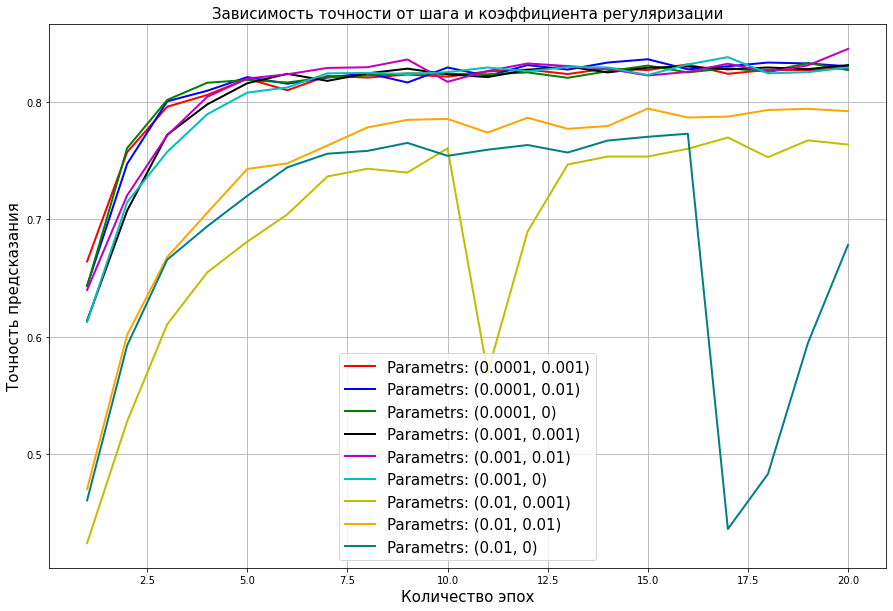

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_lion.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

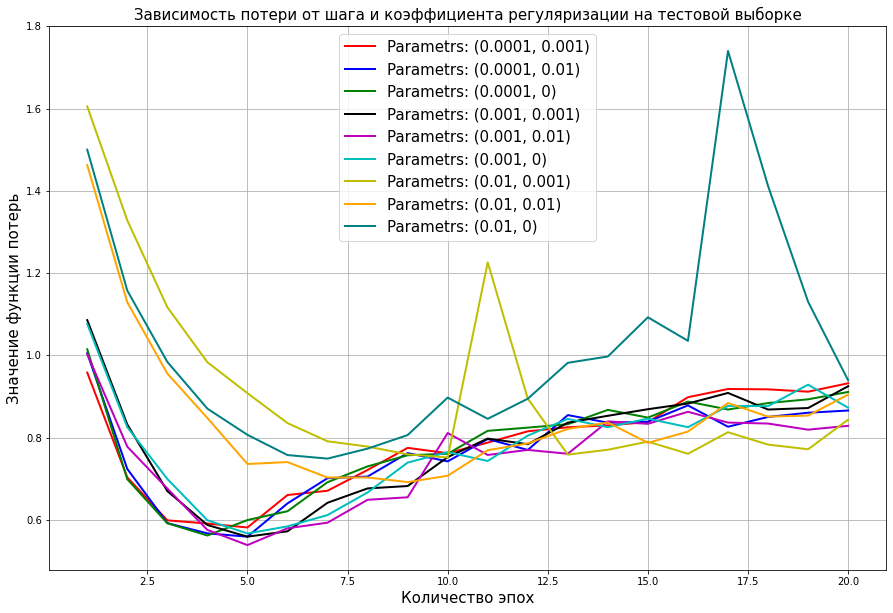

In [12]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_lion.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

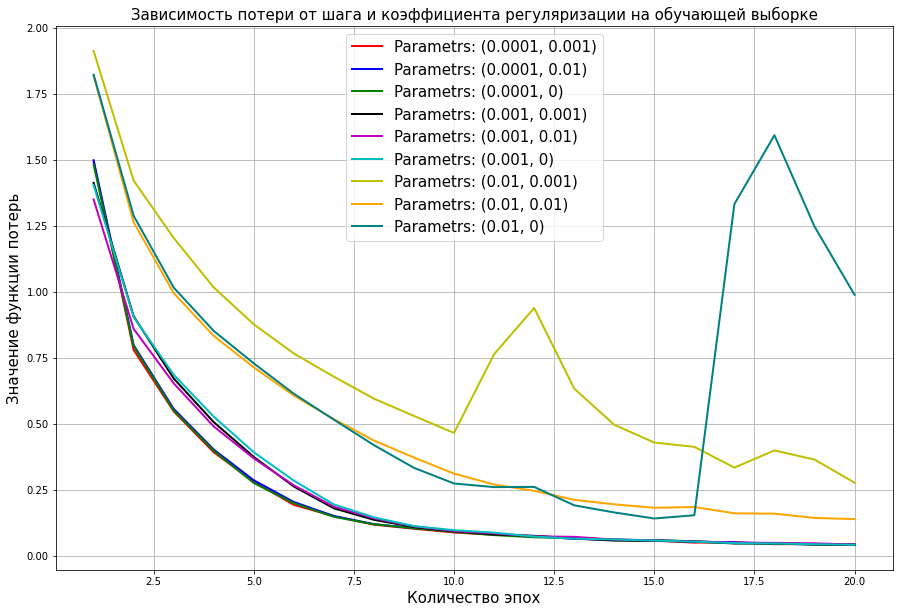

In [13]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_lion.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [16]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = Lion(lenet.parameters(), lr=0.0001, weight_decay=0.01)

test_loss_history_lion = list()
test_accuracy_history_lion = list()
loss_in_training_lion = list()
time_learning_lion = list()

for epoch in tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()

    time_learning_lion.append(time.time() - start_time)
    loss_in_training_lion.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_lion.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_lion.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_lion)
print(loss_in_training_lion)
with open('lion_bresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

  5%|▌         | 1/20 [00:23<07:19, 23.11s/it]

los epoch 0 : tensor(0.9456, device='cuda:0')
accuracy epoch 0 : 0.6612


 10%|█         | 2/20 [00:43<06:28, 21.58s/it]

los epoch 1 : tensor(0.7099, device='cuda:0')
accuracy epoch 1 : 0.7513


 15%|█▌        | 3/20 [01:04<05:58, 21.12s/it]

los epoch 2 : tensor(0.6058, device='cuda:0')
accuracy epoch 2 : 0.7882


 20%|██        | 4/20 [01:24<05:35, 20.96s/it]

los epoch 3 : tensor(0.5690, device='cuda:0')
accuracy epoch 3 : 0.8114


 25%|██▌       | 5/20 [01:45<05:14, 20.97s/it]

los epoch 4 : tensor(0.5706, device='cuda:0')
accuracy epoch 4 : 0.8194


 30%|███       | 6/20 [02:06<04:53, 20.97s/it]

los epoch 5 : tensor(0.6242, device='cuda:0')
accuracy epoch 5 : 0.8219


 35%|███▌      | 7/20 [02:27<04:32, 20.97s/it]

los epoch 6 : tensor(0.6795, device='cuda:0')
accuracy epoch 6 : 0.818


 40%|████      | 8/20 [02:48<04:12, 21.02s/it]

los epoch 7 : tensor(0.7107, device='cuda:0')
accuracy epoch 7 : 0.8141


 45%|████▌     | 9/20 [03:10<03:51, 21.06s/it]

los epoch 8 : tensor(0.7423, device='cuda:0')
accuracy epoch 8 : 0.8267


 50%|█████     | 10/20 [03:31<03:30, 21.08s/it]

los epoch 9 : tensor(0.7438, device='cuda:0')
accuracy epoch 9 : 0.8213


 55%|█████▌    | 11/20 [03:52<03:09, 21.09s/it]

los epoch 10 : tensor(0.7908, device='cuda:0')
accuracy epoch 10 : 0.8234


 60%|██████    | 12/20 [04:13<02:48, 21.10s/it]

los epoch 11 : tensor(0.8313, device='cuda:0')
accuracy epoch 11 : 0.8191


 65%|██████▌   | 13/20 [04:34<02:27, 21.09s/it]

los epoch 12 : tensor(0.8238, device='cuda:0')
accuracy epoch 12 : 0.821


 70%|███████   | 14/20 [04:55<02:06, 21.07s/it]

los epoch 13 : tensor(0.8441, device='cuda:0')
accuracy epoch 13 : 0.8202


 75%|███████▌  | 15/20 [05:16<01:45, 21.06s/it]

los epoch 14 : tensor(0.8531, device='cuda:0')
accuracy epoch 14 : 0.8229


 80%|████████  | 16/20 [05:37<01:24, 21.05s/it]

los epoch 15 : tensor(0.8526, device='cuda:0')
accuracy epoch 15 : 0.8289


 85%|████████▌ | 17/20 [05:58<01:03, 21.03s/it]

los epoch 16 : tensor(0.8820, device='cuda:0')
accuracy epoch 16 : 0.8237


 90%|█████████ | 18/20 [06:19<00:42, 21.02s/it]

los epoch 17 : tensor(0.8839, device='cuda:0')
accuracy epoch 17 : 0.8253


 95%|█████████▌| 19/20 [06:40<00:20, 20.99s/it]

los epoch 18 : tensor(0.9139, device='cuda:0')
accuracy epoch 18 : 0.825


100%|██████████| 20/20 [07:01<00:00, 21.07s/it]

los epoch 19 : tensor(0.9243, device='cuda:0')
accuracy epoch 19 : 0.825
[0.6612, 0.7513, 0.7882, 0.8114, 0.8194, 0.8219, 0.818, 0.8141, 0.8267, 0.8213, 0.8234, 0.8191, 0.821, 0.8202, 0.8229, 0.8289, 0.8237, 0.8253, 0.825, 0.825]
[1.4756395317938016, 0.7690538112883982, 0.5342164014992506, 0.393455901839163, 0.277386522260697, 0.19615288114418153, 0.14970014044286117, 0.12155991060173382, 0.0996447776120318, 0.08943446530839023, 0.08249724584874575, 0.0736176113344972, 0.06877824376418215, 0.061157304889765444, 0.05838879186903005, 0.05324206219317958, 0.050135975975907694, 0.04731599696071657, 0.0439514391053387, 0.04289500401216134]


In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [22]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = Lion(lenet.parameters(), lr=0.0003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

test_loss_history_lion = list()
test_accuracy_history_lion = list()
loss_in_training_lion = list()
time_learning_lion = list()

for epoch in tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()

    scheduler.step()
    time_learning_lion.append(time.time() - start_time)
    loss_in_training_lion.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_lion.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_lion.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_lion)
print(loss_in_training_lion)
with open('lion_bresults_scheduler.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

  5%|▌         | 1/20 [00:20<06:32, 20.65s/it]

los epoch 0 : tensor(0.8727, device='cuda:0')
accuracy epoch 0 : 0.6879


 10%|█         | 2/20 [00:41<06:14, 20.80s/it]

los epoch 1 : tensor(0.6529, device='cuda:0')
accuracy epoch 1 : 0.7756


 15%|█▌        | 3/20 [01:02<05:55, 20.89s/it]

los epoch 2 : tensor(0.5661, device='cuda:0')
accuracy epoch 2 : 0.8058


 20%|██        | 4/20 [01:23<05:35, 20.94s/it]

los epoch 3 : tensor(0.5325, device='cuda:0')
accuracy epoch 3 : 0.8259


 25%|██▌       | 5/20 [01:44<05:15, 21.01s/it]

los epoch 4 : tensor(0.5447, device='cuda:0')
accuracy epoch 4 : 0.8283


 30%|███       | 6/20 [02:05<04:54, 21.04s/it]

los epoch 5 : tensor(0.5779, device='cuda:0')
accuracy epoch 5 : 0.8314


 35%|███▌      | 7/20 [02:26<04:34, 21.08s/it]

los epoch 6 : tensor(0.6448, device='cuda:0')
accuracy epoch 6 : 0.8312


 40%|████      | 8/20 [02:48<04:13, 21.09s/it]

los epoch 7 : tensor(0.7004, device='cuda:0')
accuracy epoch 7 : 0.8366


 45%|████▌     | 9/20 [03:09<03:52, 21.12s/it]

los epoch 8 : tensor(0.7285, device='cuda:0')
accuracy epoch 8 : 0.8366


 50%|█████     | 10/20 [03:30<03:31, 21.10s/it]

los epoch 9 : tensor(0.7863, device='cuda:0')
accuracy epoch 9 : 0.8353


 55%|█████▌    | 11/20 [03:51<03:09, 21.11s/it]

los epoch 10 : tensor(0.8295, device='cuda:0')
accuracy epoch 10 : 0.8393


 60%|██████    | 12/20 [04:12<02:48, 21.08s/it]

los epoch 11 : tensor(0.8594, device='cuda:0')
accuracy epoch 11 : 0.8415


 65%|██████▌   | 13/20 [04:33<02:27, 21.07s/it]

los epoch 12 : tensor(0.9020, device='cuda:0')
accuracy epoch 12 : 0.8397


 70%|███████   | 14/20 [04:54<02:06, 21.08s/it]

los epoch 13 : tensor(0.8938, device='cuda:0')
accuracy epoch 13 : 0.8466


 75%|███████▌  | 15/20 [05:15<01:45, 21.07s/it]

los epoch 14 : tensor(0.9370, device='cuda:0')
accuracy epoch 14 : 0.8475


 80%|████████  | 16/20 [05:36<01:24, 21.05s/it]

los epoch 15 : tensor(0.9507, device='cuda:0')
accuracy epoch 15 : 0.8535


 85%|████████▌ | 17/20 [05:57<01:03, 21.06s/it]

los epoch 16 : tensor(0.9566, device='cuda:0')
accuracy epoch 16 : 0.8529


 90%|█████████ | 18/20 [06:18<00:42, 21.07s/it]

los epoch 17 : tensor(0.9699, device='cuda:0')
accuracy epoch 17 : 0.8538


 95%|█████████▌| 19/20 [06:39<00:21, 21.06s/it]

los epoch 18 : tensor(0.9480, device='cuda:0')
accuracy epoch 18 : 0.8578


100%|██████████| 20/20 [07:01<00:00, 21.05s/it]

los epoch 19 : tensor(0.9474, device='cuda:0')
accuracy epoch 19 : 0.8581
[0.6879, 0.7756, 0.8058, 0.8259, 0.8283, 0.8314, 0.8312, 0.8366, 0.8366, 0.8353, 0.8393, 0.8415, 0.8397, 0.8466, 0.8475, 0.8535, 0.8529, 0.8538, 0.8578, 0.8581]
[1.2751741020575813, 0.711213939215826, 0.5063628509640694, 0.3766609543367572, 0.2687930299050134, 0.1899460812787647, 0.13239074491531305, 0.09677591837902108, 0.07667113801909854, 0.05720152202234401, 0.04364123876894946, 0.035110685876418794, 0.024963159113742774, 0.018757590318969248, 0.012367101256171261, 0.0064652367499587375, 0.0037480591601943953, 0.0018691276565258033, 0.000682235742628425, 0.00038503737375875693]


In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [19]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = Lion(lenet.parameters(), lr=0.0001, weight_decay=0.01)

test_loss_history_lion = list()
test_accuracy_history_lion = list()
loss_in_training_lion = list()
time_learning_lion = list()

test_accuracy = 0

while test_accuracy <= 0.75:

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()

    time_learning_lion.append(time.time() - start_time)
    loss_in_training_lion.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_lion.append(los/100)
    print('los epoch:', los/100)

    test_accuracy = correct/total
    test_accuracy_history_lion.append(test_accuracy)
    print('accuracy epoch:', test_accuracy)

print(test_accuracy_history_lion)
print(loss_in_training_lion)
with open('lion_bresults_75.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

los epoch: tensor(0.9370, device='cuda:0')
accuracy epoch: 0.6659
los epoch: tensor(0.7015, device='cuda:0')
accuracy epoch: 0.7514
[0.6659, 0.7514]
[1.4546896817891495, 0.7457766914497251]
